In [58]:
from google.colab import files
import matplotlib.pyplot as plt
import math
import numpy as np
from PIL import Image as im


In [1]:
uploaded = files.upload()

Saving Bi_mp-23152_computed Profile.txt to Bi_mp-23152_computed Profile.txt


In [23]:
files_to_open = []
file_name_ending = "_Bi.txt"
for val in range(0,11,1):
  #print(val/10)
  file_name = str(val/10) + file_name_ending
  files_to_open.append(file_name)

In [24]:
files_to_open=["Bi_mp-23152_computed Profile.txt"]

In [110]:
#VALUES
scale = 5
resolution = 250

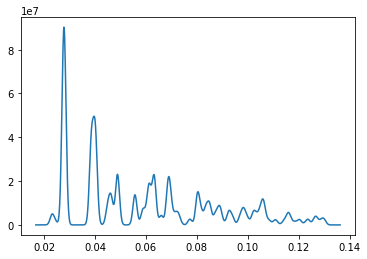

In [40]:
radii = []
intenisties = []
for file_name in files_to_open:
  file = open(file_name, "r")
  array_vals = []
  for line in file:
    data_point = line.split()

    array_vals.append([scale*math.tan(math.radians(float(data_point[0]))/2),float(data_point[1])])
  #print(array_vals)
  radius,intensity = zip(*array_vals)
  
  #angle_rad = angle_deg)/2
  radii.append(radius)
  intenisties.append(intensity)
  #print(X)
  
for i in range(0,len(radii)):
  plt.plot(radii[i],intenisties[i])


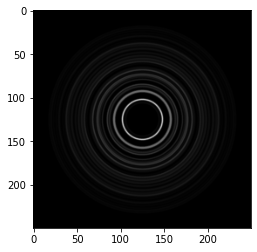

In [119]:
#source: https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
#adding an invert option because it looks cool
invert = False

X, Y = np.ogrid[:resolution,:resolution]
centre_val = resolution/2
array_ones = np.ones((resolution,resolution))
if invert:
  base_img = np.ones((resolution,resolution))*256
else:
  base_img = np.zeros((resolution,resolution))
dist_from_center = np.sqrt((X-centre_val)**2+(Y-centre_val)**2)
for i in range(0,len(radii)):
  radius = radii[i]
  intensity = intenisties[i]
  
  max_rad = radius[-1]
  radius_adjustment_value = (resolution/2)*0.9/max_rad

  prev_rad = radius[0]*radius_adjustment_value
  max_intensity = max(intensity)
  for j in range(0,len(radius)):
    #print(radius[j])
    
    curr_rad = radius[j]*radius_adjustment_value
    #print("adjusted radius: {}".format(curr_rad))
       
    mask = (dist_from_center <= curr_rad) & (dist_from_center > prev_rad)
    #mask = (dist_from_center <= 20) & (dist_from_center > 19)
    unscaled_donut = np.copy(array_ones)
    unscaled_donut[~mask]=0
    if invert:
      base_img -= unscaled_donut*intensity[j]*200/max_intensity
    else:
      base_img += unscaled_donut*intensity[j]*200/max_intensity
    prev_rad = curr_rad

#image = im.fromarray(base_img)
plt.imshow(im.fromarray(base_img))
plt.show()
#plt.imsave('DR.png', image, cmap='gray')